In [1]:
# Add the project root to Python path so we can import pyTT
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
print(f"Added {project_root} to Python path")

Added /Users/lfbarba/GitHub/smartTT to Python path


# Spherical Bessel–harmonic field demo
This notebook demonstrates how the `pyTT` library models volumetric scalar fields using spherical Bessel–harmonic bases, fits those fields to data, and extracts planar slices for visualization and testing.

## 1. Set up environment
Import PyTorch, e3nn, plotting utilities, and the `pyTT` module. We also grab NumPy, pandas, and pytest helpers for later checks.

In [2]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from e3nn import o3
import pytest
from pyTT import SphericalBesselHarmonicField
import lovely_tensors as lt
lt.monkey_patch()
torch.set_default_dtype(torch.float32)
plt.style.use("seaborn-v0_8-darkgrid")
DATA_DIR = Path("./build/notebook_artifacts")
DATA_DIR.mkdir(parents=True, exist_ok=True)
print(f"Using torch {torch.__version__} on device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Using torch 2.8.0 on device: cpu


## 2. Prepare sample data
We synthesise training points from a known spherical Bessel–harmonic combination and assemble inputs for slice visualisation later.

In [3]:
np.random.seed(42)
torch.manual_seed(42)
rng = torch.Generator().manual_seed(7)

dims = (1, 1, 1)
max_l = 2
num_radial = 2
radius = 1.0
k_init = [math.pi, 2.0 * math.pi]

truth_field = SphericalBesselHarmonicField(
    dims=dims,
    max_l=max_l,
    num_radial=num_radial,
    radius=radius,
    learn_k=False,
    k_init=k_init,
    coeff_init_scale=0.0,
    dtype=torch.get_default_dtype(),
    device=torch.device("cpu"),
)

with torch.no_grad():
    truth_field.coeffs[0][0, :, 0] = torch.tensor([0.8, -0.25])
    truth_field.coeffs[1][0, :, :] = torch.tensor(
        [[0.15, -0.05, 0.1],
         [0.05, 0.07, -0.02]]
    )
    truth_field.coeffs[2][0, :, :] = torch.tensor(
        [[0.03, -0.04, 0.02, 0.01, -0.03],
         [0.01, 0.02, -0.01, -0.02, 0.01]]
    )

def sample_points_in_sphere(num_points: int, generator: torch.Generator | None = None) -> torch.Tensor:
    direction = torch.randn(num_points, 3, generator=generator)
    direction = direction / direction.norm(dim=-1, keepdim=True)
    radius_samples = torch.rand(num_points, generator=generator).pow(1.0 / 3.0)
    return radius_samples.unsqueeze(-1) * direction

num_points = 4096
train_points = sample_points_in_sphere(num_points, generator=rng).to(truth_field.dtype).unsqueeze(0)
with torch.no_grad():
    target_values = truth_field(train_points)
target_values = target_values.detach()
train_df = pd.DataFrame(train_points.squeeze(0).numpy(), columns=["x", "y", "z"])
train_df["target"] = target_values.squeeze(0).numpy()
train_df.head()

,x,y,z,target
0,-0.611693,0.295079,0.670445,0.023618
1,-0.944828,-0.113643,0.194049,-0.024164
2,-0.325425,-0.453630,0.470324,0.324858
3,-0.237582,-0.514515,-0.204151,0.380770
4,0.405655,0.579825,0.131907,0.371969


## 3. Fit function with the library API
We train a fresh `SphericalBesselHarmonicField` instance to recover the synthetic ground-truth field via stochastic gradient descent.

In [4]:
from tqdm.auto import tqdm

model = SphericalBesselHarmonicField(
    dims=dims,
    max_l=max_l,
    num_radial=num_radial,
    radius=radius,
    learn_k=False,
    k_init=k_init,
    coeff_init_scale=0.02,
    spacing=None,
    dtype=torch.get_default_dtype(),
    device=torch.device("cpu"),
)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=800, eta_min=5e-4)
num_steps = 1200
loss_history: list[float] = []

for step in tqdm(range(1, num_steps + 1)):
    optimizer.zero_grad()
    prediction = model(train_points)
    loss = torch.mean((prediction - target_values) ** 2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_history.append(loss.item())
    if step % 100 == 0 or step == 1:
        current_lr = scheduler.get_last_lr()[0]
        print(f"step {step:04d}  loss={loss.item():.6g}  lr={current_lr:.5f}")

with torch.no_grad():
    fitted_values = model(train_points)
    residual = fitted_values - target_values
    mse = torch.mean(residual ** 2)
    max_abs_error = torch.max(residual.abs())
    fit_summary = {
        "mse": float(mse),
        "rmse": float(torch.sqrt(mse)),
        "max_abs_error": float(max_abs_error),
    }

fit_summary

  0%|          | 0/1200 [00:00<?, ?it/s]

step 0001  loss=0.107167  lr=0.00500
step 0100  loss=0.0225341  lr=0.00483
step 0200  loss=0.00313346  lr=0.00434
step 0300  loss=0.000340088  lr=0.00361
step 0200  loss=0.00313346  lr=0.00434
step 0300  loss=0.000340088  lr=0.00361
step 0400  loss=3.99276e-05  lr=0.00275
step 0500  loss=6.71777e-06  lr=0.00189
step 0400  loss=3.99276e-05  lr=0.00275
step 0500  loss=6.71777e-06  lr=0.00189
step 0600  loss=1.85143e-06  lr=0.00116
step 0700  loss=8.05547e-07  lr=0.00067
step 0600  loss=1.85143e-06  lr=0.00116
step 0700  loss=8.05547e-07  lr=0.00067
step 0800  loss=4.57467e-07  lr=0.00050
step 0900  loss=2.4673e-07  lr=0.00067
step 0800  loss=4.57467e-07  lr=0.00050
step 0900  loss=2.4673e-07  lr=0.00067
step 1000  loss=8.24191e-08  lr=0.00116
step 1100  loss=9.95455e-09  lr=0.00189
step 1000  loss=8.24191e-08  lr=0.00116
step 1100  loss=9.95455e-09  lr=0.00189
step 1200  loss=2.15865e-10  lr=0.00275
step 1200  loss=2.15865e-10  lr=0.00275


{'mse': 2.0509517695277424e-10,
 'rmse': 1.4321144590212498e-05,
 'max_abs_error': 3.528594970703125e-05}

## 4. Visualise fitted results
Compare the learned field with the ground truth over a dense spherical grid and examine convergence behaviour.

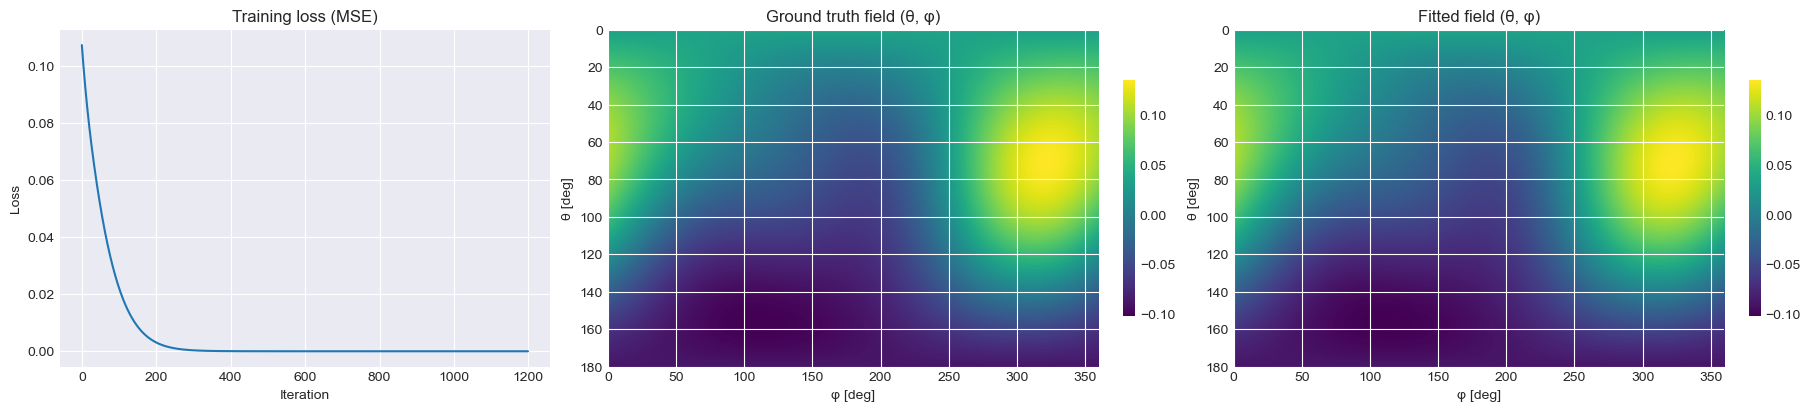

Surface max abs error: 9.462237358093262e-07


In [5]:
theta = torch.linspace(0.0, math.pi, 96)
phi = torch.linspace(0.0, 2.0 * math.pi, 192)
theta_grid, phi_grid = torch.meshgrid(theta, phi, indexing="ij")
surface_points = torch.stack(
    (
        torch.sin(theta_grid) * torch.cos(phi_grid),
        torch.sin(theta_grid) * torch.sin(phi_grid),
        torch.cos(theta_grid),
    ),
    dim=-1,
).reshape(1, -1, 3)

with torch.no_grad():
    truth_surface = truth_field(surface_points).reshape(theta_grid.shape)
    fitted_surface = model(surface_points).reshape(theta_grid.shape)
    surface_error = fitted_surface - truth_surface

fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

axes[0].plot(loss_history, color="tab:blue")
axes[0].set_title("Training loss (MSE)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

im1 = axes[1].imshow(
    truth_surface.numpy(),
    extent=[0, 360, 180, 0],
    cmap="viridis",
    aspect="auto",
)
axes[1].set_title("Ground truth field (θ, φ)")
axes[1].set_xlabel("φ [deg]")
axes[1].set_ylabel("θ [deg]")
fig.colorbar(im1, ax=axes[1], shrink=0.7)

im2 = axes[2].imshow(
    fitted_surface.numpy(),
    extent=[0, 360, 180, 0],
    cmap="viridis",
    aspect="auto",
)
axes[2].set_title("Fitted field (θ, φ)")
axes[2].set_xlabel("φ [deg]")
axes[2].set_ylabel("θ [deg]")
fig.colorbar(im2, ax=axes[2], shrink=0.7)
plt.show()

print("Surface max abs error:", float(surface_error.abs().max()))

## 5. Demonstrate slice function usage
Evaluate planar slices through a grid of spheres, masking subsets and experimenting with different orientations.

/Users/lfbarba/GitHub/smartTT/pyTT/fields.py:557: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:67.)
  k = torch.cross(ez, n)  # rotation axis (unnormalized)


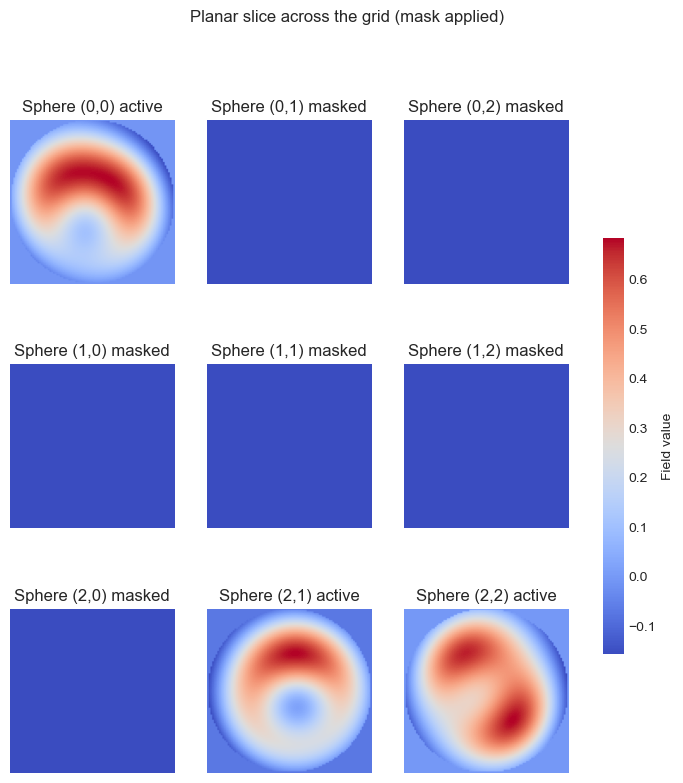

{'active_spheres': 3,
 'resolution': 96,
 'normal': [0.34912827610969543, 0.8478829860687256, 0.3990037441253662],
 'nonzero_fraction': 0.2560763955116272}

In [6]:
multi_dims = (3, 3, 1)
multi_field = SphericalBesselHarmonicField(
    dims=multi_dims,
    max_l=max_l,
    num_radial=num_radial,
    radius=radius,
    learn_k=False,
    k_init=k_init,
    coeff_init_scale=0.0,
)

with torch.no_grad():
    for l_idx, coeff in enumerate(multi_field.coeffs):
        base = model.coeffs[l_idx][0].detach()
        noise = 0.15 * torch.randn_like(coeff)
        expanded = base.unsqueeze(0).expand_as(coeff)
        coeff.copy_(expanded + noise)

mask = torch.zeros(multi_dims, dtype=torch.bool)
mask[0, 0, 0] = True
mask[2, 1, 0] = True
mask[2, 2, 0] = True

normal = torch.tensor([0.35, 0.85, 0.4])
normal = normal / normal.norm()
slice_resolution = 96

slice_tensor = multi_field.slice(normal, mask=mask, grid_resolution=slice_resolution)
slice_grid = slice_tensor[:, :, 0].cpu()

fig, axes = plt.subplots(multi_dims[0], multi_dims[1], figsize=(9, 9))
for i in range(multi_dims[0]):
    for j in range(multi_dims[1]):
        ax = axes[i, j]
        image = slice_grid[i, j].numpy()
        im = ax.imshow(
            image,
            cmap="coolwarm",
            origin="lower",
            extent=[-radius, radius, -radius, radius],
        )
        if mask[i, j, 0]:
            ax.set_title(f"Sphere ({i},{j}) active")
        else:
            ax.set_title(f"Sphere ({i},{j}) masked")
        ax.set_xticks([])
        ax.set_yticks([])
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="Field value")
fig.suptitle("Planar slice across the grid (mask applied)")
plt.show()

slice_summary = {
    "active_spheres": int(mask.sum()),
    "resolution": slice_resolution,
    "normal": normal.tolist(),
    "nonzero_fraction": float((slice_tensor.abs() > 1e-5).float().mean()),
}
slice_summary

## Interactive slice visualization
Use a slider to rotate the normal vector from 0° to 180° and observe how the slice changes through the spherical field.

In [7]:
import ipywidgets as widgets
from IPython.display import display

# Create a single sphere field for interactive slicing
interactive_field = SphericalBesselHarmonicField(
    dims=(1, 1, 1),
    max_l=max_l,
    num_radial=num_radial,
    radius=radius,
    learn_k=False,
    k_init=k_init,
    coeff_init_scale=0.0,
)

# Copy fitted coefficients to the interactive field
with torch.no_grad():
    for l_idx, coeff in enumerate(interactive_field.coeffs):
        coeff.copy_(model.coeffs[l_idx])

# Cache global color scale from a reference slice to avoid rescaling flicker
ref_normal = torch.tensor([0.0, 0.0, 1.0])
ref_slice = interactive_field.slice(ref_normal, mask=None, grid_resolution=96, extent=radius)
ref_2d = ref_slice[0, 0, 0]
_global_vmin = float(ref_2d.min())
_global_vmax = float(ref_2d.max())


def plot_slice(angle_deg):
    # Convert angle to radians and create normal vector
    angle_rad = math.radians(angle_deg)
    # Rotate around the y-axis (from z-axis toward x-axis)
    normal = torch.tensor([
        math.sin(angle_rad),
        0.0,
        math.cos(angle_rad)
    ])

    # Generate slice (uses smooth in-plane rotation inside .slice)
    slice_data = interactive_field.slice(
        normal,
        mask=None,
        grid_resolution=96,
        extent=radius
    )

    # Plot the slice
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    slice_2d = slice_data[0, 0, 0].cpu().numpy()

    im = ax.imshow(
        slice_2d,
        cmap='viridis',
        origin='lower',
        extent=[-radius, radius, -radius, radius],
        vmin=_global_vmin,
        vmax=_global_vmax,
    )

    ax.set_title(f'Slice at {angle_deg}° (normal: [{normal[0]:.3f}, {normal[1]:.3f}, {normal[2]:.3f}])')
    ax.set_xlabel('u [radius units]')
    ax.set_ylabel('v [radius units]')
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Field value')

    # Add circle to show sphere boundary
    circle = plt.Circle((0, 0), radius, fill=False, color='white', linestyle='--', alpha=0.7)
    ax.add_patch(circle)

    plt.tight_layout()
    plt.show()

# Create interactive widget
angle_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=360,
    step=1,
    description='Angle (°):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

# Create interactive plot
interactive_plot = widgets.interactive(plot_slice, angle_deg=angle_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Angle (°):', layout=Layout(width='400px'), max=360, styl…

In [8]:
for x in multi_field.parameters():
    print(x.shape)

torch.Size([9, 2, 1])
torch.Size([9, 2, 3])
torch.Size([9, 2, 5])


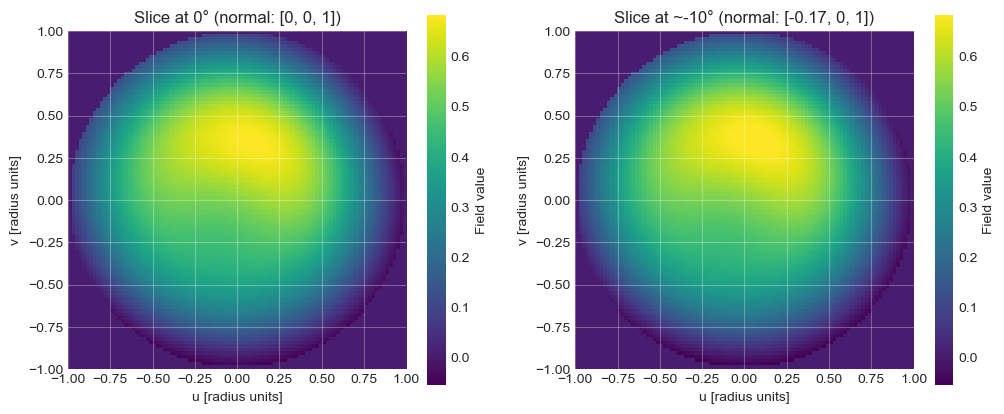

In [9]:
normal = torch.tensor([0., 0., 1.])
slice_data = interactive_field.slice(
    normal,
    mask=None,
    grid_resolution=96,
    extent=radius
)
normal = torch.tensor([-0.17, 0., 1.])
normal = normal / normal.norm()
slice_data_ = interactive_field.slice(
    normal,
    mask=None,
    grid_resolution=96,
    extent=radius
)
# show both slices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
slice_2d = slice_data[0, 0, 0].cpu().numpy()
im = axes[0].imshow(
    slice_2d,
    cmap='viridis',
    origin='lower',
    extent=[-radius, radius, -radius, radius],
    vmin=slice_2d.min(),  # keep consistent min/max across both plots for fair comparison
    vmax=slice_2d.max()
)
axes[0].set_title(f'Slice at 0° (normal: [0, 0, 1])')
axes[0].set_xlabel('u [radius units]')
axes[0].set_ylabel('v [radius units]')
axes[0].grid(True, alpha=0.3)
# Add colorbar
cbar = plt.colorbar(im, ax=axes[0], shrink=0.8)
cbar.set_label('Field value')

im = axes[1].imshow(
    slice_data_[0, 0, 0].cpu().numpy(),
    cmap='viridis',
    origin='lower',
    extent=[-radius, radius, -radius, radius],
    vmin=slice_2d.min(),
    vmax=slice_2d.max()
)
axes[1].set_title(f'Slice at ~-10° (normal: [-0.17, 0, 1])')
axes[1].set_xlabel('u [radius units]')
axes[1].set_ylabel('v [radius units]')
axes[1].grid(True, alpha=0.3)
# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], shrink=0.8)
cbar.set_label('Field value')

## Spherical shell harmonics
Extract the spherical harmonic coefficients of the fitted field on selected radii. The result exposes the full $\ell$-spectrum via e3nn irreps so downstream pipelines can operate directly on the harmonic basis.

Irreps: 1x0e+1x1o+1x2e
Radii: [0.4000000059604645, 0.800000011920929]


/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_7750/3896351655.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


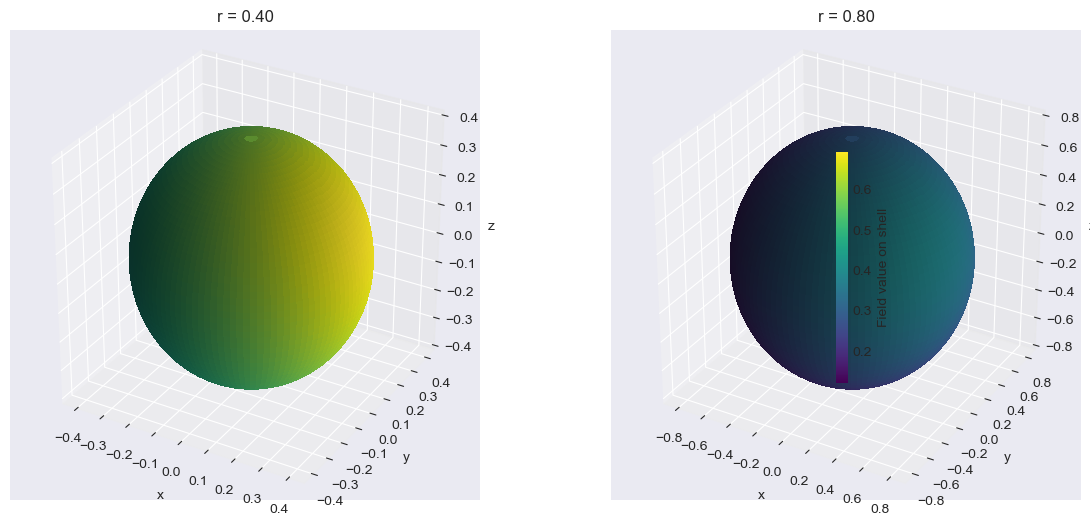

In [12]:
shell_expansion = interactive_field.shell_harmonics([0.4, 0.8], flatten=True)
print("Irreps:", shell_expansion.irreps)
print("Radii:", [float(r) for r in shell_expansion.radii])

labels = []
for l in range(max_l + 1):
    for m in range(-l, l + 1):
        labels.append(f"ℓ={l}, m={m}")

rows = [f"r={float(r):.2f}" for r in shell_expansion.radii]
coeff_table = pd.DataFrame(shell_expansion.data[0].cpu().numpy(), index=rows, columns=labels)
coeff_table

# Visualize the reconstructed spherical field values on the shells
num_t = 60
num_p = 120
theta = torch.linspace(0.0, math.pi, num_t)
phi = torch.linspace(0.0, 2.0 * math.pi, num_p)
theta_grid, phi_grid = torch.meshgrid(theta, phi, indexing="ij")
directions = torch.stack(
    (
        torch.sin(theta_grid) * torch.cos(phi_grid),
        torch.sin(theta_grid) * torch.sin(phi_grid),
        torch.cos(theta_grid),
    ),
    dim=-1,
).reshape(-1, 3)

# Pre-compute spherical harmonics for each ℓ to avoid recomputation per radius
harmonics_by_l = {}
for l in range(max_l + 1):
    harmonics_by_l[l] = o3.spherical_harmonics([l], directions, normalize=True, normalization="component")

def reconstruct_on_sphere(coeff_vector: torch.Tensor) -> torch.Tensor:
    values = torch.zeros(directions.shape[0], dtype=coeff_vector.dtype, device=coeff_vector.device)
    offset = 0
    for l in range(max_l + 1):
        dim = 2 * l + 1
        Y_l = harmonics_by_l[l]
        coeff_block = coeff_vector[offset:offset + dim]
        values += (Y_l * coeff_block).sum(dim=-1)
        offset += dim
    return values.reshape(theta_grid.shape)

shell_values = []
for radius_index in range(shell_expansion.radii.numel()):
    coeff_vector = shell_expansion.data[0, radius_index]
    shell_values.append(reconstruct_on_sphere(coeff_vector.cpu()))

values_concat = torch.stack(shell_values)
vmin = float(values_concat.min())
vmax = float(values_concat.max())

fig = plt.figure(figsize=(12, 5))
for idx, radius in enumerate(shell_expansion.radii):
    ax = fig.add_subplot(1, shell_expansion.radii.numel(), idx + 1, projection="3d")
    r_val = float(radius)
    shell_val = shell_values[idx]
    x = r_val * torch.sin(theta_grid) * torch.cos(phi_grid)
    y = r_val * torch.sin(theta_grid) * torch.sin(phi_grid)
    z = r_val * torch.cos(theta_grid)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = cm.viridis(norm(shell_val.numpy()))
    ax.plot_surface(
        x.numpy(),
        y.numpy(),
        z.numpy(),
        facecolors=colors,
        rstride=1,
        cstride=1,
        linewidth=0,
        antialiased=False,
    )
    ax.set_title(f"r = {r_val:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_box_aspect([1, 1, 1])

mappable = cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cm.viridis)
mappable.set_array([])
fig.colorbar(mappable, ax=fig.axes, shrink=0.6, label="Field value on shell")
plt.tight_layout()
plt.show()

## Visualizing individual spherical harmonics
The helper `generate_spherical_harmonic_lobes` builds the classic lobed surfaces for a chosen $(\ell, m)$ pair. We can sweep over different orders to inspect their angular structure directly.

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_7750/3492872698.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


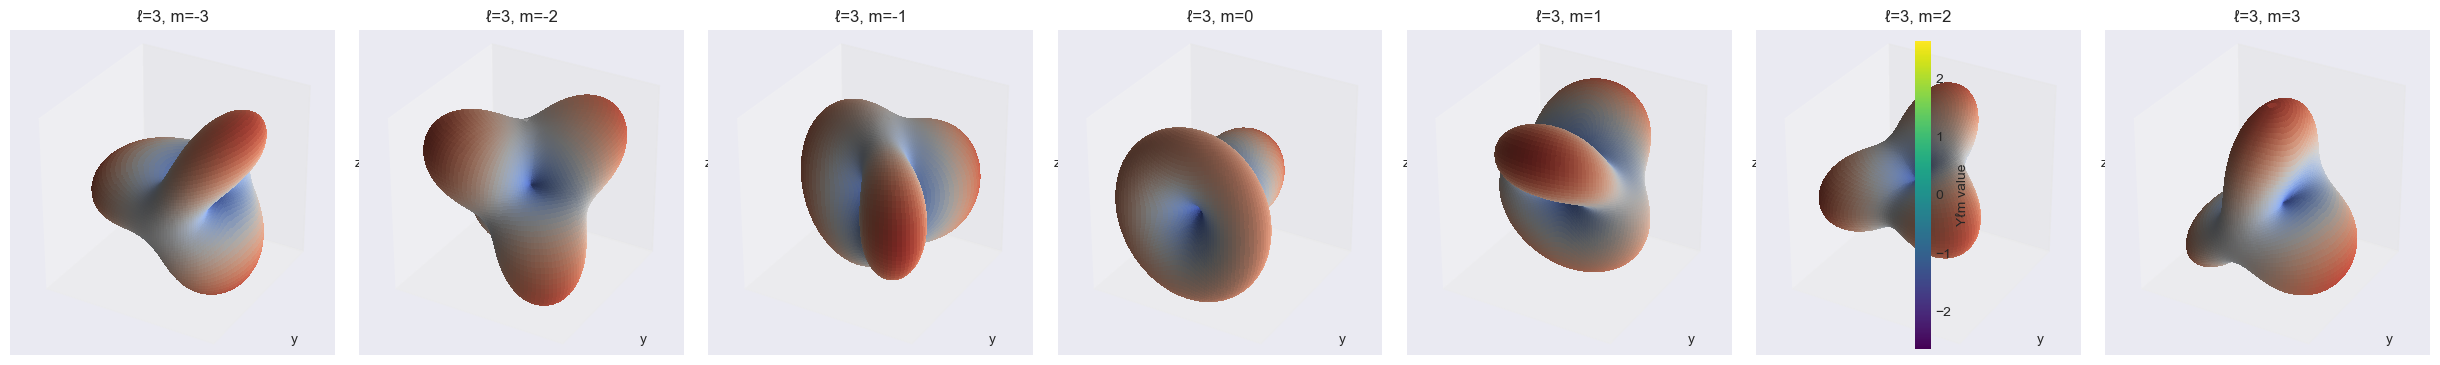

In [ ]:
from pyTT import generate_spherical_harmonic_lobes

l_value = 3
m_values = list(range(-l_value, l_value + 1))
lobes = [
    generate_spherical_harmonic_lobes(
        l_value,
        m,
        amplitude=0.35,
        theta_resolution=80,
        phi_resolution=160,
    )
    for m in m_values
]

vmin = min(float(lobe.values.min()) for lobe in lobes)
vmax = max(float(lobe.values.max()) for lobe in lobes)

fig = plt.figure(figsize=(3.5 * len(m_values), 4))
for idx, lobe in enumerate(lobes):
    ax = fig.add_subplot(1, len(m_values), idx + 1, projection="3d")
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = cm.viridis(norm(lobe.values.cpu().numpy()))
    ax.plot_surface(
        lobe.x.cpu().numpy(),
        lobe.y.cpu().numpy(),
        lobe.z.cpu().numpy(),
        facecolors=colors,
        linewidth=0,
        antialiased=False,
        rstride=1,
        cstride=1,
    )
    ax.set_title(f"ℓ={lobe.l}, m={lobe.m}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

mappable = cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cm.viridis)
mappable.set_array([])
fig.colorbar(mappable, ax=fig.axes, label="Yℓm value")
plt.tight_layout()
plt.show()